In [ ]:
#importing modules
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
from tensorflow import keras
import tensorflow as tf

In [ ]:
%mkdir checkpoints

In [ ]:
# Initialising the model architecture
model = keras.Sequential([
    # keras.layers.MaxPooling2D((2,2),input_shape = (28,28,1)),
    # keras.layers.MaxPooling2D((2,2)),
    keras.layers.RandomRotation(0.5,input_shape = (14,14,1)),

    keras.layers.Conv2D(filters = 16, padding = 'same', kernel_size = (3,3), activation = 'relu'),

    # keras.layers.Conv2D(filters = 32, padding = 'same', kernel_size = (3,3), activation = 'relu'),
    # keras.layers.Conv2D(filters = 64, padding = 'same', kernel_size = (3,3), activation = 'relu'),
    # keras.layers.MaxPooling2D((2,2)),
    # keras.layers.Conv2D(filters = 128, padding = 'same', kernel_size = (3,3), activation = 'relu'),
    keras.layers.Conv2D(filters = 256, padding = 'same', kernel_size = (3,3), activation = 'relu'),

    keras.layers.Flatten(),
    keras.layers.Dense(1000, activation = 'relu'),
    # keras.layers.Dense(11, activation = 'relu'),
    # keras.layers.Dropout(0.05),
    keras.layers.Dense(11, activation = 'sigmoid')
])

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = [keras.metrics.CategoricalAccuracy()])

# Adding Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRot  (None, 14, 14, 1)         0         
 ation)                                                          
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       37120     
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 1000)              50177000  
                                                                 
 dense_1 (Dense)             (None, 11)                11011     
                                                        

In [ ]:
# Restore the weights
new_model.load_weights('./checkpoints/Tata_Steel_Model')

##Functions

In [ ]:
# Using recursive function to remove white pixels when a cluster is detected
def recurse(arr,x,y,dir,poss):

  # directions to move in
  dirs = [[1,0],[-1,0],[0,1],[0,-1],[1,1],[-1,1],[-1,-1],[-1,1]]

  # appending current position to an array
  poss.append([x,y])
  arr[x, y] = 0

  # removing the direction where it came from, preventing returning back to the same pixel
  try:
    dirs.remove(dir)
  except:
    pass

  # Iterating for moving in different directions
  for i in dirs:
    x_2 = x + i[0]
    y_2 = y + i[1]

    # checking boundary conditions
    if(x_2>= arr.shape[0] or y_2>= arr.shape[1]):
      continue

    # sending the negative direction of movement to prevent re-going back there
    dir2 = [-i[0],-i[1]]

    # checking if value of pixel in that direction is 1 and recursing there if yes
    if (arr[x_2,y_2] == 1):
      arr,poss = recurse(arr,x_2,y_2,dir2,poss.copy())

  # returning when the whole process finishes
  return arr, poss.copy()


# recursive function to remove connected pixels for a line in the patch, similar to the earlier patch function recurse
def recurse2(arr,x,y,dir,poss, lines = []):
  dirs = [[1,0],[-1,0],[0,1],[0,-1],[1,1],[-1,1],[-1,-1],[-1,1]]

  arr[x, y] = 0

  # to get line positions
  lines.append([x,y])
  try:
    dirs.remove(dir)
  except:
    pass

  for i in dirs:
    x_2 = x + i[0]
    y_2 = y + i[1]

    # extra condition to check if pixel in the patch positions provided by the recurse function
    if(x_2>= arr.shape[0] or y_2>= arr.shape[1] or [x_2,y_2] not in poss):
      continue

    # taking dir relative to the new pixel
    dir2 = [-i[0],-i[1]]

    # checking if pixel value is 1 (white)
    if (arr[x_2,y_2] == 1):

      # recursing again with the new pixel value
      arr, _ = recurse2(arr,x_2,y_2,dir2,poss.copy(),lines)

  return arr, lines


# function to check occurence of double corners in a white patch
def check_double(arr,positions):

  count = 0
  # fig_t = plt.figure()

  # copying the array to make changes
  arr2 = np.copy(arr)

  # iteerating through positions of the patch
  for pos in positions:

    x = pos[0]
    y = pos[1]

    # If white pixel detected in the line version of the image, indicating we have hit the line in the patch
    # If we hit white pixels multiple times, it means there are multiple corners, since we removed the pixels connected to each corner line inside the patch
    # Multiple corners lines inside the patch is actually connected outside but in the patch, since they are multiple corners, and considering the patch is small
    # it must mean that one corner line did one or more corners outside that patch and returned back in that region to do another corner, since we dilated the patch point
    # it means that there corner regions got merged but lines are seperate (not connected) in that region
    if arr2[x,y] == 1:

      # calling recursive function to remove the connected white pixels of the currrently detected line inside the patch
      arr2, _ = recurse2(arr2,x,y,[0,0],poss = positions, lines = [])
      # plt.imshow(arr2, cmap='gray')

      count += 1

  # returning count - 1 since we already counted one value earlier
  return (count - 1)

# Function to check overlapping
def check_overlap(arr, g):

  g_r = [round(g[0]), round(g[1])]

  posses = []
  count = 0

  # copying the array to make changes
  arr2 = np.copy(arr)

  # setting default positions as 0 if centroid - checking region lower than 0
  pos1 = 0
  pos2 = 0

  # checking if top left corner beyond (0,0), else assigning pos1,pos2 its values
  if g_r[0] - 10 > 0 :
    pos1 = g_r[0] - 10

  if g_r[1] - 10 > 0 :
    pos2 = g_r[1] - 10

  # extracting region for checking multiple line instances
  # g_r[0] - 10 and g_r[1] - 10 checks for pos1, pos2 lying beyond 0 and adjusts accordingly
  for i in range(21 - (pos1 - (g_r[0] - 10))):
    for j in range(21- (pos2 - (g_r[1] - 10))):

       # for i values in range of initial 2 and final 2 rows, thus for all columns
       if (i < 2 - (pos1 - (g_r[0] - 10)) or i > 18 - (pos1 - (g_r[0] - 10))):

        # checking for both boundary exceed condition
        if pos1 + i > arr.shape[0] - 1  and pos2 + j > arr.shape[1] - 1 :
          break

        # checking for single boundary exceed conditions
        if pos1 + i > arr.shape[0] - 1 :
          posses.append([arr.shape[0] - 1, pos2 + j])
          continue

        if pos2 + j > arr.shape[1] - 1 :
          posses.append([pos1 + i, arr.shape[1] - 1])
          continue

        posses.append([pos1 + i, pos2 + j])

       # for i values in range between 2 and 11 thus in the limited column variation region
       elif (i >= 2 - (pos1 - (g_r[0] - 10)) and i <= 18 - (pos1 - (g_r[0] - 10))) and (j < 2 - (pos2 - (g_r[1] - 10))  or j > 18 - (pos2 - (g_r[1] - 10))):

        # checking for both boundary exceed condition
        if pos1 + i > arr.shape[0] - 1  and pos2 + j > arr.shape[1] - 1 :
          break

        # checking for single boundary exceed conditions
        if pos1 + i > arr.shape[0] - 1 :
          posses.append([arr.shape[0] - 1, pos2 + j])
          continue

        if pos2 + j > arr.shape[1] - 1 :
          posses.append([pos1 + i, arr.shape[1] - 1])
          continue

        posses.append([pos1 + i, pos2 + j])


  # print("Positions to check : ",posses)

  # variables to store line and its centroid positions
  lines = []
  g_lines = []

  # iterating through positions of the patch
  for pos in posses:

    x = pos[0]
    y = pos[1]

    # checking if pixel value is 1 (white) thus encountering a line
    if arr2[x,y] == 1:

      # print(x,y)

      # calling recursive function to remove the connected white pixels of the currently detected line inside the region and to get lines coming to the point
      arr2, line = recurse2(arr2,x,y,[0,0],poss=posses.copy(), lines=[])
      # plt.imshow(arr2, cmap='gray')

      # adding line value to the list
      lines.append(line)

      count += 1

  # making centroid array
  g_lines = np.zeros((len(lines),2))

  # calculating centroids of various line parts
  for i,line in enumerate(lines):
    line = np.array(line)
    # print(f"{line}\n\n{line.shape}")
    g_line = [line[:,0].mean(), line[:,1].mean()]
    g_lines[i,:] = np.array(g_line)

  # calculating angles
  g_new = g_lines-g
  mags = np.sum((g_new)**2,axis = 1)**0.5
  angles = np.arccos(((np.matmul(g_new, (g_new).T)/mags).T/mags))/np.pi*180

  # checking number of angles greater than 160
  n = angles[angles>=145].shape[0]//2

  # print(f"\n\n{angles.shape}\n{angles}\n{g_lines}\n{lines}\n{g}")

  # case for intersecting lines
  if n >= 2:
    return -1

  # in case of end points presents, making the count even
  if count % 2 != 0:
    count += 1

  # dividing the count by 2, since number of overlapping bends is half the number of seperate lines
  count = count//2

  # returning (count - 1) since 1 corner was already counted
  count -= 1

  # print("Overlap Count : ", count)
  return count


# function for counting number of corner, given an image which corner clusters
# arr is the cluster img, arr_or is the inverted diagram image
def count(arr, arr_or):
  # fig_t = plt.figure()
  # plt.imshow(arr, cmap='gray')
  # fig_t = plt.figure()
  # plt.imshow(arr_or, cmap='gray')

  # copying arrays to make changes
  arr_2 = np.copy(arr)
  arr_or_2 = np.copy(arr_or)
  arr_or_3 = np.copy(arr_or)

  # counting corners while iterating through image pixel by pixel
  count = 0
  for i in range(arr_2.shape[0]):
    for j in range(arr_2.shape[1]):
      i_2 = i
      j_2 = j
      posses=[]

      # checking if current pixel is white in colour, thus in a cluster
      if arr_2[i_2][j_2] == 1:
        # Increasing count and calling the function to remove the current white patch to prevent recounting pixels
        count += 1
        arr_2,posses = recurse(arr_2,i_2,j_2,[0,0],[])

        # fig_t = plt.figure()
        # plt.imshow(arr_2, cmap='gray')

        # Copying the positions that the functions detected in the patch
        posses=posses.copy()

        # Centroid calculation
        posses2= np.array(posses.copy())
        g = [posses2[:,0].mean()-2, posses2[:,1].mean()-2]
        # print("Centroid of Patch :", g)

        # Calling function to check occurence of double corner point in a cluster due to dilation and add them to count
        count += check_double(arr_or_2,posses)

        # Calling function to check overlap
        count += check_overlap(arr_or_3,g)

  # fig_t = plt.figure()
  # plt.imshow(arr_2, cmap='gray')
  return count


# sliding window cnn function
def slide_cnn(model, arr, k_size, itr_size=None, stride_b=1, stride_h=1):

  # getting the breadth,height
  b = arr.shape[1]
  h = arr.shape[0]

  # setting window = kernel size if it is None
  if itr_size == None:
    itr_size = k_size

  # calculating number of iterations along breadth and height
  h_itr = (b - itr_size[0])/stride_h + 1
  b_itr = (h - itr_size[1])/stride_b + 1

  # setting last 0th neuron prediction (indicating absence of a number) as 1, thus number is absent in start
  y_l = 1

  # pos array to store start of presence of numbers
  pos = []

  # iterating the window and sliding it
  for i in b_itr:
    for j in h_itr:

      # taking the window from the image array
      img = arr[i*stride_h:itr_size[0]+i*stride_h, j*stride_b:itr_size[1]+j*stride_b]

      # resizing it to the kernel size
      img_r = cv2.resize(img, (k_size[0], k_size[1]), interpolation=cv2.INTER_AREA)

      # reshaping into a 1 elemental 3d array
      img_f = np.zeros((1,img_r.shape[0],img_r.shape[1]))
      img_f[0,:,:] = img_r

      # making predictions from model
      prediction = model.predict(img_f)

      # converting prediction to integers
      y_pred = np.array([np.argmax(i) for i in prediction])

      # getting y_pred_pr or prediction for presence or absence of a number, 0 means present, 1 means absent
      y_pred_pr = np.zeros(y_pred.shape)
      y_pred_pr[y_pred != 0] = 1

      # checking if previous value was 0 (present) and current is 1 (absent), thus indicating end of a continous stretch of numbers (so we got the desired region to remove)
      if y_pred_pr[0] == 1 and y_l == 0:

        # setting default positions as the value where first presence was encountered
        pos1 = pos[0]
        pos2 = pos[1]

        # checking if pos was lower than 0 and setting to 0 if yes
        if pos1 < 0 :
          pos1 = 0

        if pos2 < 0 :
          pos2 = 0

        # setting posses variable to store the positions
        posses = []

        # checking maximum position values to iterate to 18 actually is for the width of a single window, if multiple windows in a row then this difference is added so that outside of that window is lines checked for
        # pos1 - pos[0] and pos2 - pos[1] is basically for the countering of the starting of the window extending beyond the image corner case
        pos1m = i*stride_h - 2
        pos2m = j*stride_b - 2

        # extracting region for checking multiple line instances
        for k in range(18 - (pos1 - pos[0]) + (pos1m - pos1)):
          for l in range(18 - (pos2 - pos[1]) + (pos2m - pos2)):

            # for i values in range of initial 2 and final 2 rows, thus for all columns
            if (k < 2 - (pos1 - pos[0]) or k > 15 - (pos1 - pos[0]) + (pos1m - pos1)):

              # checking for both boundary exceed condition
              if pos1 + k > arr.shape[0] - 1  and pos2 + l > arr.shape[1] - 1 :
                break

              # checking for single boundary exceed conditions
              if pos1 + k > arr.shape[0] - 1 :
                posses.append([arr.shape[0] - 1, pos2 + l])
                continue

              if pos2 + l > arr.shape[1] - 1 :
                posses.append([pos1 + k, arr.shape[1] - 1])
                continue

              posses.append([pos1 + k, pos2 + l])

            # for i values in range between 2 and 11 thus in the limited column variation region
            elif (k >= 2 - (pos1 - pos[0]) and k <= 15 - (pos1 - pos[0]) + (pos1m - pos1)) and (l < 2 - (pos2 - pos[1])  or l > 15 - (pos2 - pos[1]) + (pos2m - pos2)):

              # checking for both boundary exceed condition
              if pos1 + k > arr.shape[0] - 1  and pos2 + l > arr.shape[1] - 1 :
                break

              # checking for single boundary exceed conditions
              if pos1 + k > arr.shape[0] - 1 :
                posses.append([arr.shape[0] - 1, pos2 + l])
                continue

              if pos2 + l > arr.shape[1] - 1 :
                posses.append([pos1 + k, arr.shape[1] - 1])
                continue

              posses.append([pos1 + i, pos2 + j])


        # print("Positions to check : ",posses)

        # variables to store line and its centroid positions
        lines = []
        g_lines = []

        # iterating through positions of the patch
        for pos in posses:

          x = pos[0]
          y = pos[1]

          # checking if pixel value is 1 (white) thus encountering a line
          if arr[x,y] == 1:

            # print(x,y)

            # calling recursive function to remove the connected white pixels of the currently detected line inside the region and to get lines coming to the point
            arr, line = recurse2(arr,x,y,[0,0],poss=posses.copy(), lines=[])
            # plt.imshow(arr, cmap='gray')

            # adding line value to the list
            lines.append(line)

        # keeping variables to get width of the line or the centroid
        l_width = 0
        g_lines = []

        # getting approximate width of the line
        for line in lines:

          # adding line pixels to the variable
          l_width += len(line)
          line = np.array(line)

          # calculating the centroid
          g_lines.append([line[:,0].mean(), line[:,1].mean()])

        # since we have 2 regions (exit and enter) and 2 columns/rows per part (width of outer - inner box is 2), so we divide by 2*2 = 4
        l_width /= 4
        l_width = round(l_width)

        # erasing the current window to full black
        pos_win_end = [14+pos[0]+2, 14+pos[1]+2]

        # setting ending position to 2nd last row
        if pos_win_end[0] > arr.shape[0] - 2:
          pos_win_end[0] = arr.shape[0] - 2

        # setting ending position to 2nd last column
        if pos_win_end[1] > arr.shape[1] - 2:
          pos_win_end[1] = arr.shape[1] - 2

        # making the whole window black (0)
        arr[pos[0]+2:pos_win_end[0], pos[1]+2:pos_win_end[1]] = 0

        # drawing the new line to replace the old one which got erased
        cv2.line(arr, round(g_lines[0]), round(g_lines[1]), (1,1,1), l_width)/255

        # setting pos array to empty again
        pos = []

      # recording pos if encountered a new instance of a number
      if y_pred_pr[0] == 0 and y_l == 1:
        pos = [i*stride_h - 2, j*stride_b - 2]

      # recording the last predicted value (for the next iteration)
      y_l = y_pred_pr[0]


##Crop Image

In [ ]:
image = '/content/sample_img_pdf_5.PNG'
img = cv2.imread(image)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
canny_img = cv2.Canny(gray_img,30,105,3)
count_col = 0
pos = []
last_i = 0

for i in range(canny_img.shape[1]):

  # using 10th pixel column to prevent boundary case
  if canny_img[10, i] == 255:

    # checking if enough difference to detect line edge or actual diagram region
    if i > last_i + 10:
      count_col += 1
      last_i = i

      if count_col == 2 or count_col == 3:
        pos.append(i+1)
        if count_col == 3:
          break

    else:
      try:
        pos[-1] = i+1
      except:
        pass



img_cropped = gray_img[:,pos[0]+4:pos[1]-4]

##OCR Number remove

In [ ]:
!pip install easyocr

In [ ]:
reader = easyocr.Reader(['en']) # need to run only once to load model into memory
image = '/content/column_check.png'
# image_thresh = thresholded_image
results = reader.detect(image, text_threshold = 0.6)

# img = cv2.imread(image)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# for result in results:
#   top_left = tuple([int(result[0][0][0]), int(result[0][0][1])])
#   bottom_right = tuple([int(result[0][2][0]), int(result[0][2][1])])
#   # text = result[1]
#   font = cv2.FONT_HERSHEY_SIMPLEX

#   img = cv2.rectangle(img,top_left,bottom_right,(255,255,255),-1)
#   # img = cv2.putText(img,text,bottom_right, font, 0.5,(0,255,255),2,cv2.LINE_AA)


result = results[0]
horizontal_list = []
img_rect = cv2.imread(image)
for i in range(len(result[0])):
  x_min = int(result[0][i][0])
  x_max = int(result[0][i][1])
  y_min = int(result[0][i][2])
  y_max = int(result[0][i][3])

  top_left = (x_min+2, y_min+2)
  bottom_right = (x_max-2, y_max-2)
      # Rectangle for each detected text box
  img_rect = cv2.rectangle(img_rect, top_left, bottom_right, (255, 255, 255), -1)

      # Adding coordinates to the horizontal list
  horizontal_list.append([x_min, x_max, y_min, y_max])
# print("horizontal_list:", horizontal_list)
gray = cv2.cvtColor(img_rect, cv2.COLOR_BGR2GRAY)

# Threshold the image
_, thresholded_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

In [ ]:
cv2_imshow(thresholded_img)

##Tasmay Code

<ipython-input-4-ae396bdf8f29>:204: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(((np.matmul(g_new, (g_new).T)/mags).T/mags))/np.pi*180


Number of Edges =  -5 Corners =  -4 Bends =  -6
Number of Edges =  -5 Corners =  -4 Bends =  -6
Number of Edges =  -4 Corners =  -3 Bends =  -5
Number of Edges =  -4 Corners =  -3 Bends =  -5


<ipython-input-12-130c17e1152e>:169: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.tight_layout()


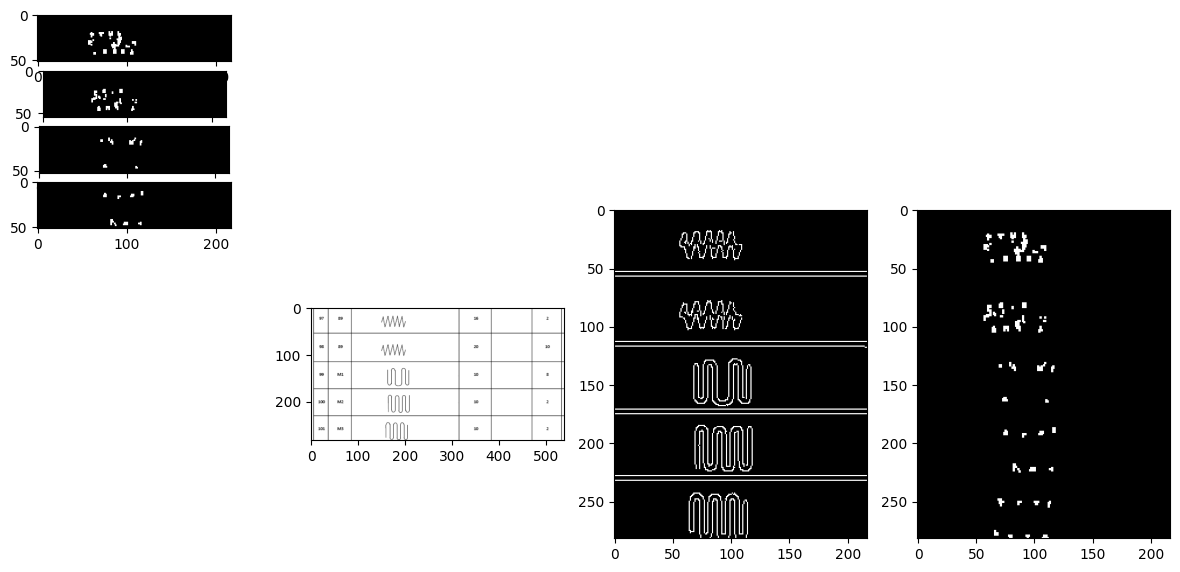

In [ ]:
# Image reading
image = cv2.imread('/content/sample_img_pdf_4_1.PNG')
gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray_img, cmap = 'gray')

# Image blurring
blur_img = cv2.GaussianBlur(gray_img, (11,11), 0)
# plt.imshow(blur_img, cmap = 'gray')

# Canny operation
canny_img = cv2.Canny(blur_img,30,105,3)
# plt.imshow(canny_img, cmap='gray')

# Detecting colummns for cropping
# Detecting rows using a similar algorithm as the column one
count_col = 0
pos = []
last_i = 0

for i in range(canny_img.shape[1]):

  # using 10th pixel column to prevent boundary case
# the first value in this which is 10 or 5 remains 10 generally
  if canny_img[10, i] == 255:

    # checking if enough difference to detect line edge or actual diagram region
    if i > last_i + 10:
      count_col += 1
      last_i = i

      if count_col == 2 or count_col == 3:
        pos.append(i+1)
        if count_col == 3:
          break

    else:
      try:
        pos[-1] = i+1
      except:
        pass



# img_cropped = gray_img[:,pos[0]+4:pos[1]-4]
img_cropped = gray_img.copy()

# plt.imshow(img_cropped, cmap='gray')



#taking inverse of the image for number detection
img_cropped_inv = np.zeros(img_cropped.shape)
img_cropped_inv = 255 - img_cropped


# implementing sliding window cnn
# img_cropped_inv_2 = img_cropped_inv.copy()
# slide_cnn(model, img_cropped_inv_2, k_size=(14,14), itr_size=None)
# img_cropped_2 = 255 - img_cropped_inv_2


# Image blurring
blur_img_cropped_2 = cv2.GaussianBlur(img_cropped_inv, (11,11), 0)
# plt.imshow(blur_img, cmap = 'gray')


# Cropping images
canny_img_cropped_2 = cv2.Canny(blur_img_cropped_2,30,105,3)
# plt.imshow(canny_img_cropped, cmap='gray')


blur_img_cropped = blur_img[:,pos[0]+4:pos[1]-4]
# plt.imshow(blur_img_cropped, cmap='gray')


# Cropping images
canny_img_cropped = canny_img[:,pos[0]+4:pos[1]-4]
# plt.imshow(canny_img_cropped, cmap='gray')


# Dilating the cropped image
dilated_img = cv2.dilate(canny_img_cropped, (1,1), iterations = 2)
# plt.imshow(dilated_img, cmap = 'gray')


# Performing Corner Detection
corner_img = cv2.cornerHarris(dilated_img, 4, 3, 0.02)
# plt.imshow(corner_img, cmap = 'gray')


# Dilating the corner detected image
c= cv2.dilate(corner_img, np.ones((2,2)), iterations = 1)
# plt.imshow(c, cmap = 'gray')


# filtered image to scale, round off and invert the original image
filtered_img = img_cropped
# plt.imshow(filtered_img, cmap = 'gray')


# Scaling the images to have values between 0 and 1
min = c.min()
max = c.max()

min2 = filtered_img.min()
max2 = filtered_img.max()

canny_img_cropped = np.around(canny_img_cropped/255)

filtered_img = (filtered_img - min2) / (max2 - min2)
a = (c - min) / (max - min)
# plt.imshow(a, cmap = 'gray')

# Applying Sigmoid and rounding off to 0 or 1, so that it is easy for us to work with
a_new = np.around(1 / (1 + np.exp(-(a-0.55))))
# plt.imshow(a_new, cmap = 'gray')

filtered_img = np.around(filtered_img)
# plt.imshow(filtered_img, cmap = 'gray')


# Inverting the original image for later recursive check
filtered_img_2 = np.copy(filtered_img)
filtered_img_2[filtered_img == 1] = 0
filtered_img_2[filtered_img == 0] = 1


# Setting recursion limit to 25k, for safety in larger images
sys.setrecursionlimit(25000)


# Final piece of code to show the image diagrams, detect rows and call functions to count corners, edges and corners
# Setting plotting stuff
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(15)

plt.subplot2grid(shape=(15, 4), loc=(0, 1), rowspan=14).imshow(img_cropped,cmap='gray')
plt.subplot2grid(shape=(15, 4), loc=(0, 2), rowspan=14).imshow(canny_img_cropped,cmap='gray')
plt.subplot2grid(shape=(15, 4), loc=(0, 3), rowspan=14).imshow(a_new,cmap='gray')
imgs = 0

# Detecting rows using a similar algorithm as the column one
last_i = 0

for i in range(canny_img_cropped.shape[0]):

  # using 10th pixel column to prevent boundary case
  if canny_img_cropped[i][10] == 1:

    # checking if enough difference to detect line edge or actual diagram region
    if i > last_i + 10:
      #-1 meaning edge not found
      corners = count(
          a_new[last_i+1:i][:], filtered_img_2[last_i+1:i][:])

      # Printing edges, corners and bends (logically number of edges = corners -1 and number of bends = corners -2)
      print("Number of Edges = ",corners-1,"Corners = ",corners,"Bends = ",corners-2)

      # plotting the cropped corner image
      plt.subplot2grid(shape=(14, 4), loc=(imgs, 0), rowspan=1).imshow(a_new[last_i+1:i][:],cmap='gray')

      imgs += 1
      last_i = i

    else:
      last_i = i

plt.tight_layout()

# displaying the plot
plt.show()